In [21]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from mpl_toolkits.mplot3d import Axes3D

def sigmoid(a):
    return 1.0/(1+ np.exp(-a))

def sigmoid_derivative(a):
    return sigmoid(a)*(1-sigmoid(a))

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1.0 - np.tanh(x)**2

def identity(x):
    return x

def identity_derivative(x):
    return 1

class NeuralNetwork:
    def __init__(self, layers, h, epsilon, name = ''):    #Architecture Intitialization
        self.name = name
        self.layers = len(layers)
        self.a = []
        self.z = []
        self.h = h
        self.epsilon = epsilon  #Tune weight initialization (https://www.youtube.com/watch?v=OF8ocg5mgx0)
        self.weights = []
        self.delta = []
        self.gradient = []

        for i in range(self.layers-2):  #Weight Intitialization
            np.random.seed(100)
            self.weights.append(np.random.randn(layers[i]+1, layers[i+1]+1)*2*self.epsilon - self.epsilon)
        np.random.seed(100)
        self.weights.append(np.random.randn(layers[-2]+1, layers[-1])*2*self.epsilon - self.epsilon)

    def predict(self,X):  #Inference
        a = [X]
        z = []
        b = np.ones([1,a[0].shape[0]]).reshape(a[0].shape[0],1)
        a[0] = np.concatenate((b,a[0]), axis=1)
        
        for i in range(self.layers-1):
            z.append(np.dot(a[i],self.weights[i]))
            if(self.h[i] == 'sigmoid'):
                a.append(sigmoid(z[i]))
            elif(self.h[i] == 'tanh'):
                a.append(tanh(z[i]))
            elif(self.h[i] == 'identity'):
                a.append(identity(z[i])) 
        return a[-1]        
        
    def feedForward(self, X):  #Forward pass
        a = [X]
        z = []
        b = np.ones([1,a[0].shape[0]]).reshape(a[0].shape[0],1)
        a[0] = np.concatenate((b,a[0]), axis=1)
        
        for i in range(self.layers-1):
            z.append(np.dot(a[i],self.weights[i]))
            if(self.h[i] == 'sigmoid'):
                a.append(sigmoid(z[i]))
            elif(self.h[i] == 'tanh'):
                a.append(tanh(z[i]))
            elif(self.h[i] == 'identity'):
                a.append(identity(z[i]))
        self.a = a
        self.z = z
    
    def backProp(self,y): #Back pass
        delta = []
        gradient = []
        weights_flipped = self.weights[::-1]
        z_flipped = self.z[::-1]
        h_flipped = self.a[::-1]
        activation_func_flipped = self.h[::-1]
        delta.append(h_flipped[0] - y)
        
        for i in range(0,self.layers-2):
                if(activation_func_flipped[i] == 'sigmoid'):
                    delta.append( np.dot(delta[i], weights_flipped[i].T )*sigmoid_derivative(z_flipped[i+1]) )
                elif(activation_func_flipped[i] == 'tanh'):
                    delta.append( np.dot(delta[i], weights_flipped[i].T )*tanh_derivative(z_flipped[i+1]) )
                elif(activation_func_flipped[i] == 'identity'):
                    delta.append( np.dot(delta[i], weights_flipped[i].T )*identity_derivative(z_flipped[i+1]) )
                    
        delta = delta[::-1]
        for i in range(len(delta)):
            gradient.append( np.dot(self.a[i].T, delta[i]) )
        self.delta = delta
        self.gradient = gradient
            
    def train(self, epochs, learning_rate, X, y, cost_func, metrics_at=10):  #Fit Model
        start = time.time()
        cost=[]
        
        for i in range(epochs):
                self.feedForward(X)
                self.backProp(y)
                for j in range(len(self.gradient)):
                    self.weights[j] = self.weights[j] - learning_rate * self.gradient[j]

                if(i%metrics_at == 0):
                    self.feedForward(X)
                    if(cost_func == 'log_loss'):
                        cost.append(self.log_loss(y))
                    elif(cost_func == 'least_squares_loss'):
                        cost.append(self.least_squares_loss(y))
                        
        end = time.time()
        print('Runtime: ', end-start, ' seconds')
        if(cost_func == 'log_loss'):
            print('Classification Accuracy: ', np.mean(np.round(self.predict(X))==y) * 100, '%')
        print(self.name + ' Training Error: ', cost[-1], '\n')
        
        if(cost_func== 'log_loss'):
            plt.figure()
            lin = np.linspace(0,len(cost),len(cost))
            plt.plot(lin,cost)
        elif(cost_func == 'least_squares_loss'):
            plt.figure()
            lin = np.linspace(0,len(cost),len(cost))
            plt.plot(lin,cost)
            
        return self.weights

    def least_squares_loss(self,t):
        return 0.5*np.mean( (t-self.a[-1])**2 )

    def log_loss(self,t):
        return log_loss(t,self.a[-1])
  

Runtime:  0.5103578567504883  seconds
Classification Accuracy:  100.0 %
XOR Training Error:  0.008366072297296082 



Text(0.5, 0.92, 'XOR Decision Surface')

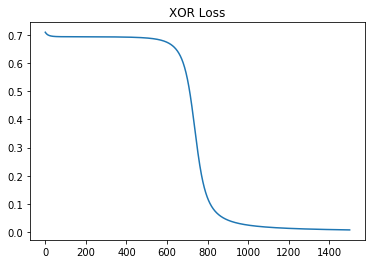

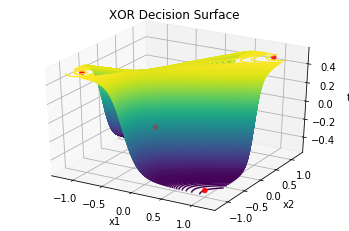

In [22]:
X = np.array([[-1, -1],[1, 1],[-1, 1],[1, -1]]) #XOR problem
t = np.array([1, 1, 0, 0]).reshape(4,1)

NN = NeuralNetwork([2,2,1], h=['tanh','sigmoid'], epsilon = 0.13, name = 'XOR')  #a) One Hidden Layer w/ 2 units
w = NN.train(epochs=1500, learning_rate=0.1, X=X, y=t, cost_func='log_loss', metrics_at=1)
plt.title('XOR Loss')

x_mesh = np.linspace(-1.2,1.2,50).reshape(50,1)
y_mesh = np.linspace(-1.2,1.2,50).reshape(50,1)
X_mesh, Y_mesh = np.meshgrid(x_mesh,x_mesh)

predicitions = np.zeros([len(x_mesh),len(y_mesh)])
for i in range(len(X_mesh)):
    for j in range(len(Y_mesh)):
        pt = np.array([X_mesh[i,j],Y_mesh[i,j]]).reshape(1,2)
        predicitions[i,j] = NN.predict(pt)[0,0]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X_mesh, Y_mesh, predicitions-0.5,1000)

x1 = [-1, 1, -1, 1]
x2 = [-1, 1, 1, -1]
t_xor = [0.5, 0.5, -0.5, -0.5]
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('t')
ax.scatter(x1, x2, t_xor, c='r')
plt.title('XOR Decision Surface')

Runtime:  0.9204354286193848  seconds
3 Tanh Training Error:  0.2936990462082234 

Runtime:  0.33968019485473633  seconds
20 Tanh Training Error:  0.041654623349686795 



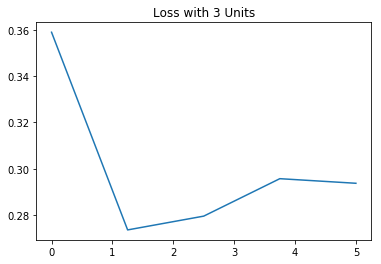

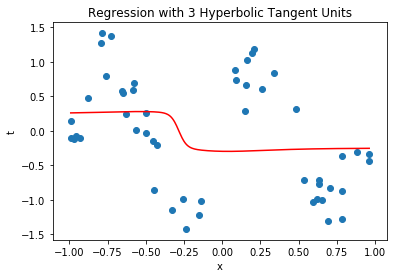

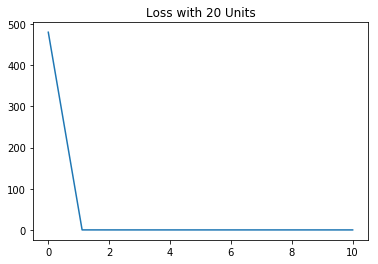

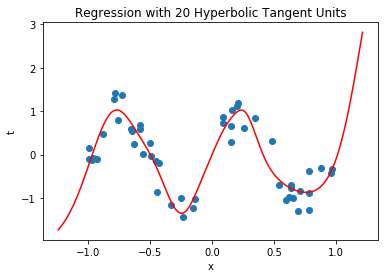

In [23]:
np.random.seed(100)
X = np.sort(2*np.random.rand(50,1)-1)
t = np.sin(2*(np.pi)*X) + 0.3*np.random.randn(50,1)

NN2 = NeuralNetwork([1,3,1], h=['tanh','identity'],epsilon=0.1, name = '3 Tanh')  #b.ii) One Hidden Layer w/ 3 tanh units
w = NN2.train(epochs=50000, learning_rate=0.001, X=X, y=t, cost_func='least_squares_loss', metrics_at=10000)
plt.title('Loss with 3 Units')

x_mesh = np.linspace(np.min(X),np.max(X),500).reshape(500,1)
y = NN2.predict(x_mesh)

plt.figure()
plt.plot(x_mesh,y,'r')
plt.scatter(X,t)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Regression with 3 Hyperbolic Tangent Units')

NN3 = NeuralNetwork([1,20,1], h=['tanh','identity'],epsilon=2.21, name = '20 Tanh')   #b.iii) One Hidden Layer w/ 20 tanh units
w = NN3.train(epochs=10000, learning_rate=0.001, X=X, y=t, cost_func='least_squares_loss', metrics_at=1000)
plt.title('Loss with 20 Units')

x_mesh = np.linspace(np.min(X)-0.25,np.max(X)+0.25,500).reshape(500,1)
y = NN3.predict(x_mesh)

plt.figure()
plt.plot(x_mesh,y,'r')
plt.scatter(X,t)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Regression with 20 Hyperbolic Tangent Units')

plt.show()